In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets

from utils.data import *

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

%load_ext autoreload
%autoreload 2

cuda


# DATA

In [2]:
TRAIN_FLAG = True
#DATA_SET = 'Shapes'
DATA_SET = 'Circles'
#DATA_SET = 'MNIST'

In [3]:
import matplotlib.pyplot as plt

def plot_grid(data, grid_size=4):
    mat_data = data.data if hasattr(data, 'data') else data

    _, ax = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(8,8))

    for i in range(grid_size):
        for j in range(grid_size):
            ax[i][j].imshow(mat_data[i*grid_size+j].movedim(0, 2), cmap='gray')
            ax[i][j].axis('off')
    plt.tight_layout(pad=0.5)

[[  0 522]
 [  1 478]]
(1000, 1, 28, 28)
torch.Size([160, 1, 28, 28]) torch.Size([40, 1, 28, 28])
tensor(0.) tensor(1.)
CPU times: user 647 ms, sys: 120 ms, total: 767 ms
Wall time: 589 ms


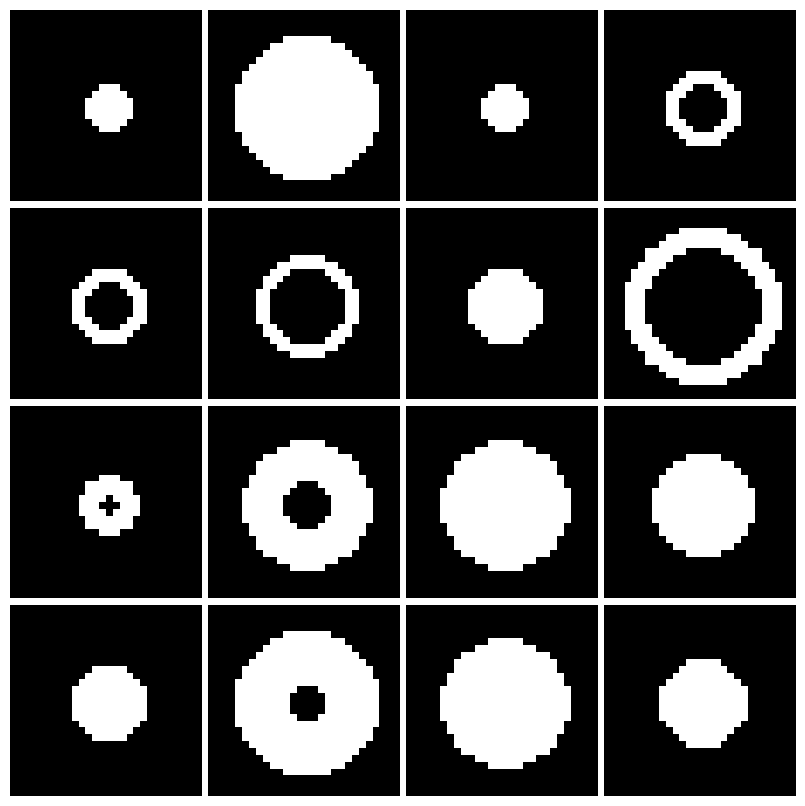

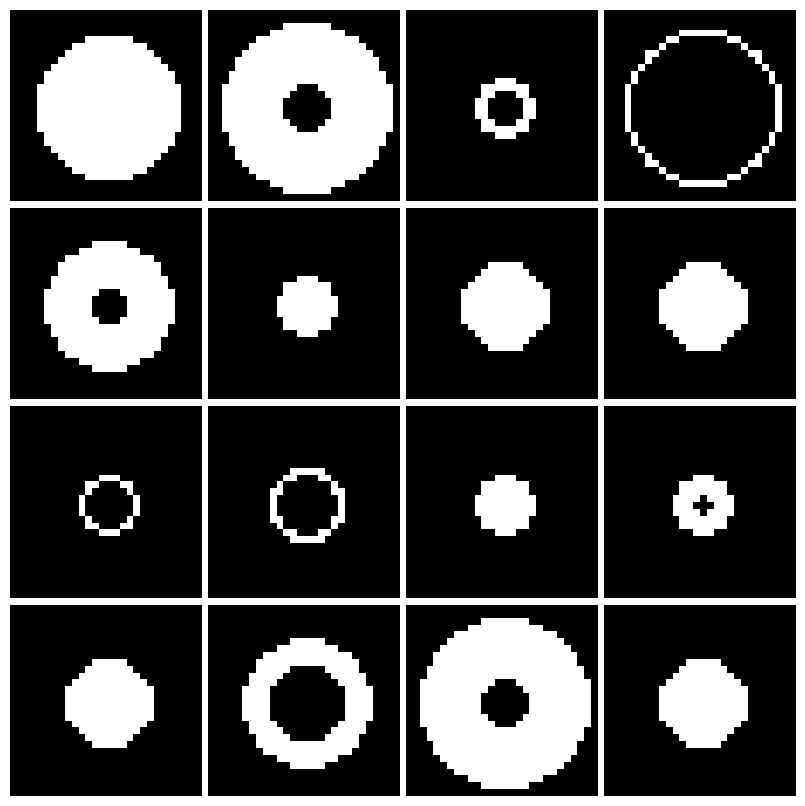

In [4]:
%%time

if DATA_SET == 'Circles' :
    img_size = 28
    
    shapes, targets = gen_circles_dataset(num_images=1000, image_size=img_size, seed=42)
    print(np.array(np.unique(targets, return_counts=True)).T)
    
    shapes = shapes.reshape(-1, 1, img_size, img_size) / 255.
    print(shapes.shape)

    subsampled_indeces = sample_indices(targets, k=100, max_classes=None, seed=42)
    train_indeces = random.sample(subsampled_indeces, int(0.8*len(subsampled_indeces)))
    test_indeces = list(set(subsampled_indeces)-set(train_indeces))
        
    train_dataset = torch.from_numpy(shapes[train_indeces].astype(np.float32))
    eval_dataset = torch.from_numpy(shapes[test_indeces].astype(np.float32))

    train_labels = targets[train_indeces]
    eval_labels = targets[test_indeces]

elif DATA_SET == 'Shapes' :
    shapes, targets = load_shapes_dataset()
    shapes = 1 - shapes.reshape(-1, 1, 28, 28) / 255.
    print(shapes.shape)

    # train_indeces = sample_indices(targets, k=90, seed=42)
    # remaining_indeces = list(set(range(len(targets)))-set(train_indeces))
    # test_indeces = sample_indices(targets[remaining_indeces], k=10, seed=42)
    subsampled_indeces = sample_indices(targets, k=100, max_classes=2, seed=42)
    train_indeces = random.sample(subsampled_indeces, int(0.8*len(subsampled_indeces)))
    test_indeces = list(set(subsampled_indeces)-set(train_indeces))
        
    train_dataset = torch.from_numpy(shapes[train_indeces].astype(np.float32))
    eval_dataset = torch.from_numpy(shapes[test_indeces].astype(np.float32))

    train_labels = targets[train_indeces]
    eval_labels = targets[test_indeces]

elif DATA_SET == 'MNIST' :
    mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

    # train_indeces = sample_indices(mnist_trainset.targets, k=500, max_classes=2, seed=42)
    # remaining_indeces = list(set(range(len(mnist_trainset.targets)))-set(train_indeces))
    # test_indeces = sample_indices(mnist_trainset.targets[remaining_indeces], k=50, seed=42)

    subsampled_indeces = sample_indices(mnist_trainset.targets, k=100, max_classes=None, seed=42)
    train_indeces = random.sample(subsampled_indeces, int(0.8*len(subsampled_indeces)))
    test_indeces = list(set(subsampled_indeces)-set(train_indeces))

    train_dataset = mnist_trainset.data[train_indeces].reshape(-1, 1, 28, 28) / 255.
    eval_dataset = mnist_trainset.data[test_indeces].reshape(-1, 1, 28, 28) / 255.

    train_labels = mnist_trainset.targets[train_indeces]
    eval_labels = mnist_trainset.targets[test_indeces]

print(train_dataset.shape, eval_dataset.shape)
print(train_dataset.min(), train_dataset.max())

# train_dataset = torch.bernoulli(train_dataset)
# eval_dataset = torch.bernoulli(eval_dataset)

plot_grid(train_dataset)
plot_grid(eval_dataset)

In [5]:
print(train_dataset.shape, train_dataset.min(), train_dataset.max(), train_dataset.mean(), train_dataset.std())
print(eval_dataset.shape, eval_dataset.min(), eval_dataset.max(), eval_dataset.mean(), eval_dataset.std())

torch.Size([160, 1, 28, 28]) tensor(0.) tensor(1.) tensor(0.2260) tensor(0.4182)
torch.Size([40, 1, 28, 28]) tensor(0.) tensor(1.) tensor(0.2477) tensor(0.4317)


In [6]:
# train_mean, train_std = train_dataset.mean(), train_dataset.std()
# train_dataset -= train_mean / train_std
# eval_dataset -= train_mean / train_std

# TRAIN

## Configure Training

In [7]:
from pythae.models import *
from pythae.models.nn.benchmarks.mnist import *
from pythae.models.nn.default_architectures import *
from pythae.models.base.base_utils import ModelOutput
from utils.models import Encoder_VAE_TinyMLP, Decoder_AE_TinyMLP

architecture_dict = {
    'tiny':
        {
        'encoder': Encoder_VAE_TinyMLP,
        'decoder': Decoder_AE_TinyMLP,
        },
    'mlp':
        {
        'encoder': Encoder_VAE_MLP,
        'decoder': Decoder_AE_MLP,
        },
    'convnet':
        {
        'encoder': Encoder_Conv_VAE_MNIST,
        'decoder': Decoder_Conv_AE_MNIST,
        },
    'resnet':
        {
        'encoder': Encoder_ResNet_VAE_MNIST,
        'decoder': Decoder_ResNet_AE_MNIST,
        },
    }

In [8]:
model_config = RHVAEConfig(
    input_dim=(1, img_size, img_size),
    latent_dim=2,
    reconstruction_loss="bce",
    n_lf=3,
    eps_lf=1e-3,
    beta_zero=0.3,
    temperature=0.8,
    regularization=1e-2
)

model = RHVAE(
    model_config=model_config,
    encoder=architecture_dict['tiny']['encoder'](model_config),
    decoder=architecture_dict['tiny']['decoder'](model_config),
)

# model_config = VAEConfig(
#     input_dim=(1, 28, 28),
#     latent_dim=2,
#     reconstruction_loss="bce",
# )

# model = VAE(
#     model_config=model_config,
#     encoder=architecture_dict['tiny']['encoder'](model_config),
#     decoder=architecture_dict['tiny']['decoder'](model_config),
# )

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

%time count_parameters(model)

CPU times: user 82 µs, sys: 25 µs, total: 107 µs
Wall time: 111 µs


946391

In [10]:
print(model)

RHVAE(
  (decoder): Decoder_AE_TinyMLP(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
  (encoder): Encoder_VAE_TinyMLP(
    (layers): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=400, bias=True)
      (2): ReLU()
    )
    (embedding): Linear(in_features=400, out_features=2, bias=True)
    (log_var): Linear(in_features=400, out_features=2, bias=True)
  )
  (metric): Metric_MLP(
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU()
    )
    (diag): Linear(in_features=400, out_features=2, bias=True)
    (lower): Linear(in_features=400, out_features=1, bias=True)
  )
)


## Train

In [11]:
%%time

from pythae.trainers import BaseTrainerConfig, BaseTrainer
from pythae.trainers.training_callbacks import TrainHistoryCallback
from pythae.pipelines.training import TrainingPipeline

training_config = BaseTrainerConfig(
    output_dir='experiments',
    num_epochs=500,
    learning_rate=1e-4,
    per_device_train_batch_size=len(train_dataset),
    per_device_eval_batch_size=len(eval_dataset),
    #optimizer_cls="AdamW",
    #optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.99)},
    scheduler_cls="ReduceLROnPlateau",
    scheduler_params={"patience": 10, "factor": 0.5, "verbose": True}
)

pipeline = TrainingPipeline(
        training_config=training_config,
        model=model
)

callbacks = []
history_cb = TrainHistoryCallback()
callbacks.append(history_cb)

if TRAIN_FLAG:
    pipeline(
        train_data=train_dataset,
        eval_data=eval_dataset,
        callbacks=callbacks
    )
else:
    pass

Preprocessing train data...
Checking train dataset...
Preprocessing eval data...

Checking eval dataset...
Using Base Trainer

Model passed sanity check !
Ready for training.

Created experiments/RHVAE_training_2024-06-10_16-43-20. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 500
 - per_device_train_batch_size: 160
 - per_device_eval_batch_size: 40
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7f351c93e9e0>

Successfully launched training !



Training of epoch 1/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 1/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 567.3409
Eval loss: 545.6241
--------------------------------------------------------------------------


Training of epoch 2/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 2/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 563.0002
Eval loss: 544.5065
--------------------------------------------------------------------------


Training of epoch 3/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 3/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 558.7555
Eval loss: 543.4368
--------------------------------------------------------------------------


Training of epoch 4/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 4/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 556.3544
Eval loss: 540.4797
--------------------------------------------------------------------------


Training of epoch 5/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 5/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 552.6074
Eval loss: 536.8295
--------------------------------------------------------------------------


Training of epoch 6/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 6/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 548.8049
Eval loss: 535.8039
--------------------------------------------------------------------------


Training of epoch 7/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 7/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 542.5705
Eval loss: 533.0399
--------------------------------------------------------------------------


Training of epoch 8/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 8/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 538.9155
Eval loss: 531.4845
--------------------------------------------------------------------------


Training of epoch 9/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 9/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 536.7391
Eval loss: 530.0226
--------------------------------------------------------------------------


Training of epoch 10/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 10/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 532.539
Eval loss: 528.6616
--------------------------------------------------------------------------


Training of epoch 11/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 11/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 530.1909
Eval loss: 523.9597
--------------------------------------------------------------------------


Training of epoch 12/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 12/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 528.7249
Eval loss: 522.4828
--------------------------------------------------------------------------


Training of epoch 13/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 13/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 521.3996
Eval loss: 519.4069
--------------------------------------------------------------------------


Training of epoch 14/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 14/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 520.7451
Eval loss: 518.0148
--------------------------------------------------------------------------


Training of epoch 15/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 15/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 516.8786
Eval loss: 515.6033
--------------------------------------------------------------------------


Training of epoch 16/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 16/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 514.1046
Eval loss: 514.0405
--------------------------------------------------------------------------


Training of epoch 17/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 17/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 511.7666
Eval loss: 512.5383
--------------------------------------------------------------------------


Training of epoch 18/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 18/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 506.7733
Eval loss: 507.4583
--------------------------------------------------------------------------


Training of epoch 19/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 19/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 504.8647
Eval loss: 505.6523
--------------------------------------------------------------------------


Training of epoch 20/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 20/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 504.2416
Eval loss: 503.3752
--------------------------------------------------------------------------


Training of epoch 21/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 21/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 500.045
Eval loss: 502.2717
--------------------------------------------------------------------------


Training of epoch 22/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 22/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 495.0987
Eval loss: 498.5556
--------------------------------------------------------------------------


Training of epoch 23/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 23/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 493.9302
Eval loss: 495.6358
--------------------------------------------------------------------------


Training of epoch 24/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 24/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 490.7117
Eval loss: 496.1084
--------------------------------------------------------------------------


Training of epoch 25/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 25/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 487.5347
Eval loss: 490.3213
--------------------------------------------------------------------------


Training of epoch 26/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 26/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 483.157
Eval loss: 487.8285
--------------------------------------------------------------------------


Training of epoch 27/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 27/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 480.724
Eval loss: 487.0142
--------------------------------------------------------------------------


Training of epoch 28/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 28/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 477.2987
Eval loss: 478.5807
--------------------------------------------------------------------------


Training of epoch 29/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 29/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 473.7528
Eval loss: 477.5489
--------------------------------------------------------------------------


Training of epoch 30/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 30/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 469.1746
Eval loss: 475.7119
--------------------------------------------------------------------------


Training of epoch 31/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 31/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 468.2979
Eval loss: 473.4848
--------------------------------------------------------------------------


Training of epoch 32/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 32/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 462.5724
Eval loss: 464.0903
--------------------------------------------------------------------------


Training of epoch 33/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 33/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 460.6466
Eval loss: 467.1817
--------------------------------------------------------------------------


Training of epoch 34/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 34/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 457.5341
Eval loss: 466.1724
--------------------------------------------------------------------------


Training of epoch 35/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 35/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 454.2243
Eval loss: 471.0064
--------------------------------------------------------------------------


Training of epoch 36/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 36/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 446.9001
Eval loss: 454.7933
--------------------------------------------------------------------------


Training of epoch 37/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 37/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 441.3639
Eval loss: 459.0864
--------------------------------------------------------------------------


Training of epoch 38/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 38/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 440.5679
Eval loss: 453.6176
--------------------------------------------------------------------------


Training of epoch 39/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 39/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 432.3457
Eval loss: 441.2632
--------------------------------------------------------------------------


Training of epoch 40/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 40/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 434.0848
Eval loss: 446.2155
--------------------------------------------------------------------------


Training of epoch 41/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 41/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 427.9373
Eval loss: 436.545
--------------------------------------------------------------------------


Training of epoch 42/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 42/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 417.668
Eval loss: 440.1461
--------------------------------------------------------------------------


Training of epoch 43/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 43/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 421.4996
Eval loss: 436.2216
--------------------------------------------------------------------------


Training of epoch 44/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 44/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 419.8345
Eval loss: 446.9056
--------------------------------------------------------------------------


Training of epoch 45/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 45/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 414.5676
Eval loss: 432.8745
--------------------------------------------------------------------------


Training of epoch 46/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 46/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 409.2141
Eval loss: 414.5023
--------------------------------------------------------------------------


Training of epoch 47/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 47/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 403.8855
Eval loss: 416.525
--------------------------------------------------------------------------


Training of epoch 48/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 48/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 400.3578
Eval loss: 416.3086
--------------------------------------------------------------------------


Training of epoch 49/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 49/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 398.9818
Eval loss: 419.1866
--------------------------------------------------------------------------


Training of epoch 50/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 50/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 397.0533
Eval loss: 408.4781
--------------------------------------------------------------------------


Training of epoch 51/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 51/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 388.3156
Eval loss: 411.9974
--------------------------------------------------------------------------


Training of epoch 52/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 52/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 390.2839
Eval loss: 403.9565
--------------------------------------------------------------------------


Training of epoch 53/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 53/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 377.5567
Eval loss: 400.3546
--------------------------------------------------------------------------


Training of epoch 54/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 54/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 382.7502
Eval loss: 395.8658
--------------------------------------------------------------------------


Training of epoch 55/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 55/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 375.6591
Eval loss: 398.4626
--------------------------------------------------------------------------


Training of epoch 56/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 56/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 365.8221
Eval loss: 386.4433
--------------------------------------------------------------------------


Training of epoch 57/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 57/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 367.1421
Eval loss: 383.3842
--------------------------------------------------------------------------


Training of epoch 58/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 58/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 370.6368
Eval loss: 391.8747
--------------------------------------------------------------------------


Training of epoch 59/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 59/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 366.0544
Eval loss: 374.4337
--------------------------------------------------------------------------


Training of epoch 60/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 60/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 362.2826
Eval loss: 376.9864
--------------------------------------------------------------------------


Training of epoch 61/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 61/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 362.3831
Eval loss: 372.4259
--------------------------------------------------------------------------


Training of epoch 62/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 62/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 355.5586
Eval loss: 369.8253
--------------------------------------------------------------------------


Training of epoch 63/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 63/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 348.9499
Eval loss: 365.3267
--------------------------------------------------------------------------


Training of epoch 64/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 64/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 357.8941
Eval loss: 370.8824
--------------------------------------------------------------------------


Training of epoch 65/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 65/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 356.4561
Eval loss: 367.0544
--------------------------------------------------------------------------


Training of epoch 66/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 66/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 351.9312
Eval loss: 354.3048
--------------------------------------------------------------------------


Training of epoch 67/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 67/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 340.0759
Eval loss: 361.3604
--------------------------------------------------------------------------


Training of epoch 68/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 68/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 338.3911
Eval loss: 339.1972
--------------------------------------------------------------------------


Training of epoch 69/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 69/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 335.42
Eval loss: 350.675
--------------------------------------------------------------------------


Training of epoch 70/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 70/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 339.1111
Eval loss: 351.063
--------------------------------------------------------------------------


Training of epoch 71/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 71/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 327.8477
Eval loss: 341.5122
--------------------------------------------------------------------------


Training of epoch 72/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 72/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 335.9749
Eval loss: 342.3874
--------------------------------------------------------------------------


Training of epoch 73/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 73/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 329.2909
Eval loss: 341.0467
--------------------------------------------------------------------------


Training of epoch 74/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 74/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 325.4809
Eval loss: 336.0213
--------------------------------------------------------------------------


Training of epoch 75/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 75/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 328.8694
Eval loss: 327.7472
--------------------------------------------------------------------------


Training of epoch 76/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 76/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 325.7228
Eval loss: 336.1069
--------------------------------------------------------------------------


Training of epoch 77/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 77/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 324.4263
Eval loss: 323.4801
--------------------------------------------------------------------------


Training of epoch 78/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 78/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 320.3979
Eval loss: 336.5616
--------------------------------------------------------------------------


Training of epoch 79/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 79/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 313.6118
Eval loss: 314.787
--------------------------------------------------------------------------


Training of epoch 80/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 80/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 307.905
Eval loss: 307.9629
--------------------------------------------------------------------------


Training of epoch 81/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 81/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 302.2053
Eval loss: 317.0105
--------------------------------------------------------------------------


Training of epoch 82/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 82/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 308.5865
Eval loss: 311.5396
--------------------------------------------------------------------------


Training of epoch 83/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 83/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 303.087
Eval loss: 323.7953
--------------------------------------------------------------------------


Training of epoch 84/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 84/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 298.6165
Eval loss: 314.3602
--------------------------------------------------------------------------


Training of epoch 85/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 85/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 297.0647
Eval loss: 308.233
--------------------------------------------------------------------------


Training of epoch 86/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 86/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 291.8572
Eval loss: 297.3958
--------------------------------------------------------------------------


Training of epoch 87/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 87/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 301.395
Eval loss: 296.0126
--------------------------------------------------------------------------


Training of epoch 88/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 88/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 290.4053
Eval loss: 312.7538
--------------------------------------------------------------------------


Training of epoch 89/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 89/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 288.1505
Eval loss: 302.0185
--------------------------------------------------------------------------


Training of epoch 90/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 90/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 287.1919
Eval loss: 301.434
--------------------------------------------------------------------------


Training of epoch 91/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 91/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 284.7434
Eval loss: 289.7598
--------------------------------------------------------------------------


Training of epoch 92/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 92/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 288.3587
Eval loss: 276.4378
--------------------------------------------------------------------------


Training of epoch 93/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 93/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 278.2764
Eval loss: 286.5622
--------------------------------------------------------------------------


Training of epoch 94/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 94/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 284.4112
Eval loss: 272.6997
--------------------------------------------------------------------------


Training of epoch 95/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 95/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 269.5614
Eval loss: 284.0997
--------------------------------------------------------------------------


Training of epoch 96/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 96/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 276.9564
Eval loss: 275.6394
--------------------------------------------------------------------------


Training of epoch 97/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 97/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 277.1281
Eval loss: 264.0334
--------------------------------------------------------------------------


Training of epoch 98/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 98/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 269.0678
Eval loss: 263.2455
--------------------------------------------------------------------------


Training of epoch 99/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 99/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 271.6858
Eval loss: 273.6364
--------------------------------------------------------------------------


Training of epoch 100/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 100/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 271.798
Eval loss: 263.8638
--------------------------------------------------------------------------


Training of epoch 101/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 101/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 257.48
Eval loss: 257.5472
--------------------------------------------------------------------------


Training of epoch 102/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 102/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 262.2561
Eval loss: 259.0385
--------------------------------------------------------------------------


Training of epoch 103/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 103/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 251.209
Eval loss: 244.6717
--------------------------------------------------------------------------


Training of epoch 104/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 104/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 251.781
Eval loss: 243.6669
--------------------------------------------------------------------------


Training of epoch 105/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 105/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 252.433
Eval loss: 255.3603
--------------------------------------------------------------------------


Training of epoch 106/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 106/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 243.1345
Eval loss: 251.7574
--------------------------------------------------------------------------


Training of epoch 107/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 107/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 241.5588
Eval loss: 249.1647
--------------------------------------------------------------------------


Training of epoch 108/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 108/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 235.2707
Eval loss: 243.6845
--------------------------------------------------------------------------


Training of epoch 109/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 109/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 240.5335
Eval loss: 233.8615
--------------------------------------------------------------------------


Training of epoch 110/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 110/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 230.7088
Eval loss: 234.2654
--------------------------------------------------------------------------


Training of epoch 111/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 111/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 237.1437
Eval loss: 238.5078
--------------------------------------------------------------------------


Training of epoch 112/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 112/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 231.4419
Eval loss: 233.5723
--------------------------------------------------------------------------


Training of epoch 113/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 113/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 231.1827
Eval loss: 223.9812
--------------------------------------------------------------------------


Training of epoch 114/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 114/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 226.856
Eval loss: 225.136
--------------------------------------------------------------------------


Training of epoch 115/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 115/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 219.0147
Eval loss: 217.1807
--------------------------------------------------------------------------


Training of epoch 116/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 116/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 222.9227
Eval loss: 216.3264
--------------------------------------------------------------------------


Training of epoch 117/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 117/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 218.988
Eval loss: 221.1407
--------------------------------------------------------------------------


Training of epoch 118/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 118/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 221.8899
Eval loss: 220.6506
--------------------------------------------------------------------------


Training of epoch 119/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 119/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 214.6153
Eval loss: 220.8462
--------------------------------------------------------------------------


Training of epoch 120/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 120/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 214.4368
Eval loss: 215.4967
--------------------------------------------------------------------------


Training of epoch 121/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 121/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 209.0657
Eval loss: 221.2756
--------------------------------------------------------------------------


Training of epoch 122/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 122/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 210.0407
Eval loss: 205.5672
--------------------------------------------------------------------------


Training of epoch 123/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 123/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 207.1122
Eval loss: 204.4689
--------------------------------------------------------------------------


Training of epoch 124/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 124/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 204.6183
Eval loss: 201.7659
--------------------------------------------------------------------------


Training of epoch 125/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 125/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 205.7661
Eval loss: 209.8957
--------------------------------------------------------------------------


Training of epoch 126/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 126/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 202.8225
Eval loss: 191.0551
--------------------------------------------------------------------------


Training of epoch 127/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 127/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 203.3389
Eval loss: 196.6256
--------------------------------------------------------------------------


Training of epoch 128/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 128/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 197.3138
Eval loss: 198.7697
--------------------------------------------------------------------------


Training of epoch 129/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 129/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 197.1855
Eval loss: 191.7719
--------------------------------------------------------------------------


Training of epoch 130/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 130/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 195.597
Eval loss: 194.4271
--------------------------------------------------------------------------


Training of epoch 131/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 131/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 196.1327
Eval loss: 197.4754
--------------------------------------------------------------------------


Training of epoch 132/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 132/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 194.196
Eval loss: 188.0258
--------------------------------------------------------------------------


Training of epoch 133/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 133/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 193.2764
Eval loss: 186.4876
--------------------------------------------------------------------------


Training of epoch 134/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 134/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 190.8725
Eval loss: 185.5973
--------------------------------------------------------------------------


Training of epoch 135/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 135/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 187.8731
Eval loss: 184.2855
--------------------------------------------------------------------------


Training of epoch 136/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 136/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 190.4736
Eval loss: 184.4961
--------------------------------------------------------------------------


Training of epoch 137/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 137/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 185.8174
Eval loss: 195.7409
--------------------------------------------------------------------------


Training of epoch 138/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 138/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 181.6091
Eval loss: 192.6651
--------------------------------------------------------------------------


Training of epoch 139/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 139/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 179.6837
Eval loss: 185.4526
--------------------------------------------------------------------------


Training of epoch 140/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 140/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 182.1295
Eval loss: 177.3445
--------------------------------------------------------------------------


Training of epoch 141/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 141/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 182.9573
Eval loss: 184.587
--------------------------------------------------------------------------


Training of epoch 142/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 142/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 180.4729
Eval loss: 178.7165
--------------------------------------------------------------------------


Training of epoch 143/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 143/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 180.7008
Eval loss: 179.403
--------------------------------------------------------------------------


Training of epoch 144/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 144/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 179.5482
Eval loss: 175.0125
--------------------------------------------------------------------------


Training of epoch 145/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 145/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 180.5052
Eval loss: 178.3504
--------------------------------------------------------------------------


Training of epoch 146/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 146/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 173.3315
Eval loss: 172.5029
--------------------------------------------------------------------------


Training of epoch 147/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 147/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 172.6658
Eval loss: 179.5562
--------------------------------------------------------------------------


Training of epoch 148/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 148/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.4031
Eval loss: 177.1024
--------------------------------------------------------------------------


Training of epoch 149/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 149/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 174.9978
Eval loss: 181.0541
--------------------------------------------------------------------------


Training of epoch 150/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 150/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 170.5835
Eval loss: 175.1319
--------------------------------------------------------------------------


Training of epoch 151/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 151/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 168.9039
Eval loss: 174.8099
--------------------------------------------------------------------------


Training of epoch 152/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 152/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 169.7411
Eval loss: 169.9594
--------------------------------------------------------------------------


Training of epoch 153/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 153/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 167.1535
Eval loss: 169.4551
--------------------------------------------------------------------------


Training of epoch 154/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 154/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 165.4234
Eval loss: 171.7803
--------------------------------------------------------------------------


Training of epoch 155/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 155/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 168.1487
Eval loss: 174.5513
--------------------------------------------------------------------------


Training of epoch 156/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 156/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 163.465
Eval loss: 163.82
--------------------------------------------------------------------------


Training of epoch 157/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 157/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 166.6218
Eval loss: 174.911
--------------------------------------------------------------------------


Training of epoch 158/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 158/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 163.1047
Eval loss: 165.4998
--------------------------------------------------------------------------


Training of epoch 159/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 159/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 163.6462
Eval loss: 167.4996
--------------------------------------------------------------------------


Training of epoch 160/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 160/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 163.8983
Eval loss: 162.1648
--------------------------------------------------------------------------


Training of epoch 161/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 161/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 159.4992
Eval loss: 163.3661
--------------------------------------------------------------------------


Training of epoch 162/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 162/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 157.9976
Eval loss: 160.69
--------------------------------------------------------------------------


Training of epoch 163/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 163/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 161.1503
Eval loss: 162.652
--------------------------------------------------------------------------


Training of epoch 164/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 164/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 157.3722
Eval loss: 165.848
--------------------------------------------------------------------------


Training of epoch 165/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 165/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 158.362
Eval loss: 155.3347
--------------------------------------------------------------------------


Training of epoch 166/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 166/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 155.8993
Eval loss: 164.4542
--------------------------------------------------------------------------


Training of epoch 167/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 167/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 154.9707
Eval loss: 165.6479
--------------------------------------------------------------------------


Training of epoch 168/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 168/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 154.5254
Eval loss: 162.1735
--------------------------------------------------------------------------


Training of epoch 169/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 169/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 155.0585
Eval loss: 159.1796
--------------------------------------------------------------------------


Training of epoch 170/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 170/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 154.7346
Eval loss: 165.6173
--------------------------------------------------------------------------


Training of epoch 171/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 171/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 153.7034
Eval loss: 157.0323
--------------------------------------------------------------------------


Training of epoch 172/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 172/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 154.0066
Eval loss: 167.1419
--------------------------------------------------------------------------


Training of epoch 173/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 173/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 151.1258
Eval loss: 151.9772
--------------------------------------------------------------------------


Training of epoch 174/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 174/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 146.728
Eval loss: 157.5661
--------------------------------------------------------------------------


Training of epoch 175/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 175/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 147.9095
Eval loss: 157.2616
--------------------------------------------------------------------------


Training of epoch 176/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 176/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 147.3531
Eval loss: 150.3992
--------------------------------------------------------------------------


Training of epoch 177/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 177/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 145.5002
Eval loss: 152.9036
--------------------------------------------------------------------------


Training of epoch 178/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 178/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 145.3002
Eval loss: 158.5173
--------------------------------------------------------------------------


Training of epoch 179/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 179/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 143.42
Eval loss: 150.0114
--------------------------------------------------------------------------


Training of epoch 180/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 180/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 144.2934
Eval loss: 154.0819
--------------------------------------------------------------------------


Training of epoch 181/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 181/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 145.4253
Eval loss: 161.8993
--------------------------------------------------------------------------


Training of epoch 182/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 182/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 141.2225
Eval loss: 149.415
--------------------------------------------------------------------------


Training of epoch 183/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 183/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 144.3494
Eval loss: 152.6919
--------------------------------------------------------------------------


Training of epoch 184/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 184/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 139.6233
Eval loss: 151.0085
--------------------------------------------------------------------------


Training of epoch 185/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 185/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 144.4947
Eval loss: 144.2168
--------------------------------------------------------------------------


Training of epoch 186/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 186/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 140.5802
Eval loss: 154.0345
--------------------------------------------------------------------------


Training of epoch 187/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 187/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 141.8091
Eval loss: 154.7045
--------------------------------------------------------------------------


Training of epoch 188/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 188/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 139.1435
Eval loss: 150.7425
--------------------------------------------------------------------------


Training of epoch 189/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 189/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 141.4633
Eval loss: 144.6977
--------------------------------------------------------------------------


Training of epoch 190/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 190/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 137.3095
Eval loss: 148.2839
--------------------------------------------------------------------------


Training of epoch 191/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 191/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 134.3302
Eval loss: 146.322
--------------------------------------------------------------------------


Training of epoch 192/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 192/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 139.0921
Eval loss: 144.4116
--------------------------------------------------------------------------


Training of epoch 193/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 193/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 135.5064
Eval loss: 144.9209
--------------------------------------------------------------------------


Training of epoch 194/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 194/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 135.5525
Eval loss: 150.8876
--------------------------------------------------------------------------


Training of epoch 195/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 195/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 137.6599
Eval loss: 147.1784
--------------------------------------------------------------------------


Training of epoch 196/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 196/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 135.1814
Eval loss: 150.1887
--------------------------------------------------------------------------


Epoch 00196: reducing learning rate of group 0 to 5.0000e-05.


Training of epoch 197/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 197/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 135.97
Eval loss: 146.5072
--------------------------------------------------------------------------


Training of epoch 198/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 198/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 133.8386
Eval loss: 141.2201
--------------------------------------------------------------------------


Training of epoch 199/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 199/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 131.1148
Eval loss: 143.4942
--------------------------------------------------------------------------


Training of epoch 200/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 200/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 132.2784
Eval loss: 150.2288
--------------------------------------------------------------------------


Training of epoch 201/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 201/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 133.205
Eval loss: 141.1889
--------------------------------------------------------------------------


Training of epoch 202/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 202/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 132.0889
Eval loss: 144.511
--------------------------------------------------------------------------


Training of epoch 203/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 203/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 132.8676
Eval loss: 141.7376
--------------------------------------------------------------------------


Training of epoch 204/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 204/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 128.9574
Eval loss: 143.8181
--------------------------------------------------------------------------


Training of epoch 205/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 205/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 132.3891
Eval loss: 142.2496
--------------------------------------------------------------------------


Training of epoch 206/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 206/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 130.3864
Eval loss: 142.9172
--------------------------------------------------------------------------


Training of epoch 207/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 207/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 130.5907
Eval loss: 133.3841
--------------------------------------------------------------------------


Training of epoch 208/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 208/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 130.1927
Eval loss: 141.5838
--------------------------------------------------------------------------


Training of epoch 209/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 209/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 128.6748
Eval loss: 148.9682
--------------------------------------------------------------------------


Training of epoch 210/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 210/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 128.634
Eval loss: 138.606
--------------------------------------------------------------------------


Training of epoch 211/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 211/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 131.2456
Eval loss: 141.3381
--------------------------------------------------------------------------


Training of epoch 212/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 212/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 130.8131
Eval loss: 134.751
--------------------------------------------------------------------------


Training of epoch 213/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 213/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 129.4607
Eval loss: 142.7361
--------------------------------------------------------------------------


Training of epoch 214/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 214/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 129.1175
Eval loss: 140.7926
--------------------------------------------------------------------------


Training of epoch 215/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 215/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 127.1699
Eval loss: 140.266
--------------------------------------------------------------------------


Training of epoch 216/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 216/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.2407
Eval loss: 143.7761
--------------------------------------------------------------------------


Training of epoch 217/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 217/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 128.005
Eval loss: 143.9859
--------------------------------------------------------------------------


Training of epoch 218/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 218/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 128.5034
Eval loss: 134.3722
--------------------------------------------------------------------------


Epoch 00218: reducing learning rate of group 0 to 2.5000e-05.


Training of epoch 219/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 219/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.7529
Eval loss: 140.4755
--------------------------------------------------------------------------


Training of epoch 220/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 220/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 128.4141
Eval loss: 142.8074
--------------------------------------------------------------------------


Training of epoch 221/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 221/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 127.645
Eval loss: 138.924
--------------------------------------------------------------------------


Training of epoch 222/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 222/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.6253
Eval loss: 147.9337
--------------------------------------------------------------------------


Training of epoch 223/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 223/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.6162
Eval loss: 139.1691
--------------------------------------------------------------------------


Training of epoch 224/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 224/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 128.4204
Eval loss: 141.9651
--------------------------------------------------------------------------


Training of epoch 225/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 225/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 127.0393
Eval loss: 136.4961
--------------------------------------------------------------------------


Training of epoch 226/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 226/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.2008
Eval loss: 136.3495
--------------------------------------------------------------------------


Training of epoch 227/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 227/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.3126
Eval loss: 140.608
--------------------------------------------------------------------------


Training of epoch 228/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 228/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 127.852
Eval loss: 138.1829
--------------------------------------------------------------------------


Training of epoch 229/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 229/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.2734
Eval loss: 139.7977
--------------------------------------------------------------------------


Epoch 00229: reducing learning rate of group 0 to 1.2500e-05.


Training of epoch 230/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 230/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.0733
Eval loss: 134.8691
--------------------------------------------------------------------------


Training of epoch 231/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 231/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.1993
Eval loss: 137.9087
--------------------------------------------------------------------------


Training of epoch 232/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 232/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.2692
Eval loss: 138.2305
--------------------------------------------------------------------------


Training of epoch 233/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 233/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.574
Eval loss: 136.959
--------------------------------------------------------------------------


Training of epoch 234/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 234/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 127.3676
Eval loss: 140.4245
--------------------------------------------------------------------------


Training of epoch 235/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 235/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.4821
Eval loss: 141.4729
--------------------------------------------------------------------------


Training of epoch 236/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 236/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.173
Eval loss: 137.9091
--------------------------------------------------------------------------


Training of epoch 237/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 237/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.039
Eval loss: 136.7261
--------------------------------------------------------------------------


Training of epoch 238/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 238/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.955
Eval loss: 141.242
--------------------------------------------------------------------------


Training of epoch 239/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 239/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.5738
Eval loss: 140.3178
--------------------------------------------------------------------------


Training of epoch 240/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 240/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 127.4063
Eval loss: 137.2612
--------------------------------------------------------------------------


Epoch 00240: reducing learning rate of group 0 to 6.2500e-06.


Training of epoch 241/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 241/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.8532
Eval loss: 135.1276
--------------------------------------------------------------------------


Training of epoch 242/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 242/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 127.145
Eval loss: 136.7749
--------------------------------------------------------------------------


Training of epoch 243/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 243/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.4233
Eval loss: 133.457
--------------------------------------------------------------------------


Training of epoch 244/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 244/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 127.3061
Eval loss: 134.7494
--------------------------------------------------------------------------


Training of epoch 245/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 245/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.1946
Eval loss: 137.0259
--------------------------------------------------------------------------


Training of epoch 246/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 246/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.8892
Eval loss: 138.765
--------------------------------------------------------------------------


Training of epoch 247/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 247/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.1157
Eval loss: 146.2871
--------------------------------------------------------------------------


Training of epoch 248/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 248/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.8395
Eval loss: 137.0934
--------------------------------------------------------------------------


Training of epoch 249/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 249/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 127.2014
Eval loss: 139.1652
--------------------------------------------------------------------------


Training of epoch 250/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 250/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.9561
Eval loss: 138.4213
--------------------------------------------------------------------------


Training of epoch 251/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 251/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.1559
Eval loss: 138.067
--------------------------------------------------------------------------


Epoch 00251: reducing learning rate of group 0 to 3.1250e-06.


Training of epoch 252/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 252/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.566
Eval loss: 135.0712
--------------------------------------------------------------------------


Training of epoch 253/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 253/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.7166
Eval loss: 136.3203
--------------------------------------------------------------------------


Training of epoch 254/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 254/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.1494
Eval loss: 137.9668
--------------------------------------------------------------------------


Training of epoch 255/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 255/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.4451
Eval loss: 138.047
--------------------------------------------------------------------------


Training of epoch 256/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 256/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.8874
Eval loss: 137.4594
--------------------------------------------------------------------------


Training of epoch 257/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 257/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 129.0177
Eval loss: 130.6797
--------------------------------------------------------------------------


Training of epoch 258/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 258/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.425
Eval loss: 131.2128
--------------------------------------------------------------------------


Training of epoch 259/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 259/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.1148
Eval loss: 135.505
--------------------------------------------------------------------------


Training of epoch 260/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 260/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.436
Eval loss: 137.7281
--------------------------------------------------------------------------


Training of epoch 261/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 261/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.9097
Eval loss: 135.5929
--------------------------------------------------------------------------


Training of epoch 262/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 262/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 127.245
Eval loss: 142.7314
--------------------------------------------------------------------------


Training of epoch 263/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 263/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.625
Eval loss: 133.8423
--------------------------------------------------------------------------


Training of epoch 264/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 264/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.0943
Eval loss: 135.8117
--------------------------------------------------------------------------


Training of epoch 265/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 265/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 127.323
Eval loss: 133.0171
--------------------------------------------------------------------------


Training of epoch 266/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 266/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.9619
Eval loss: 140.7151
--------------------------------------------------------------------------


Training of epoch 267/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 267/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.5168
Eval loss: 133.3498
--------------------------------------------------------------------------


Training of epoch 268/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 268/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.0336
Eval loss: 136.4441
--------------------------------------------------------------------------


Epoch 00268: reducing learning rate of group 0 to 1.5625e-06.


Training of epoch 269/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 269/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.3925
Eval loss: 139.2171
--------------------------------------------------------------------------


Training of epoch 270/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 270/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.8275
Eval loss: 142.2008
--------------------------------------------------------------------------


Training of epoch 271/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 271/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.7987
Eval loss: 138.3503
--------------------------------------------------------------------------


Training of epoch 272/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 272/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.0639
Eval loss: 137.6732
--------------------------------------------------------------------------


Training of epoch 273/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 273/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.754
Eval loss: 143.0677
--------------------------------------------------------------------------


Training of epoch 274/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 274/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.9881
Eval loss: 128.536
--------------------------------------------------------------------------


Training of epoch 275/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 275/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.0712
Eval loss: 136.4294
--------------------------------------------------------------------------


Training of epoch 276/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 276/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.3314
Eval loss: 134.1823
--------------------------------------------------------------------------


Training of epoch 277/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 277/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.8148
Eval loss: 133.06
--------------------------------------------------------------------------


Training of epoch 278/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 278/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.9697
Eval loss: 134.8033
--------------------------------------------------------------------------


Training of epoch 279/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 279/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.6564
Eval loss: 138.685
--------------------------------------------------------------------------


Training of epoch 280/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 280/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.0413
Eval loss: 138.2527
--------------------------------------------------------------------------


Training of epoch 281/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 281/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.1743
Eval loss: 136.3381
--------------------------------------------------------------------------


Training of epoch 282/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 282/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.6254
Eval loss: 137.3923
--------------------------------------------------------------------------


Training of epoch 283/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 283/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.5685
Eval loss: 138.6539
--------------------------------------------------------------------------


Training of epoch 284/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 284/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.6127
Eval loss: 135.4042
--------------------------------------------------------------------------


Training of epoch 285/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 285/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.2699
Eval loss: 132.9406
--------------------------------------------------------------------------


Epoch 00285: reducing learning rate of group 0 to 7.8125e-07.


Training of epoch 286/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 286/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.6655
Eval loss: 135.1322
--------------------------------------------------------------------------


Training of epoch 287/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 287/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.8298
Eval loss: 135.2448
--------------------------------------------------------------------------


Training of epoch 288/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 288/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.2822
Eval loss: 132.658
--------------------------------------------------------------------------


Training of epoch 289/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 289/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.7433
Eval loss: 134.0781
--------------------------------------------------------------------------


Training of epoch 290/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 290/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.4968
Eval loss: 136.2963
--------------------------------------------------------------------------


Training of epoch 291/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 291/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.9509
Eval loss: 131.796
--------------------------------------------------------------------------


Training of epoch 292/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 292/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.8714
Eval loss: 135.5925
--------------------------------------------------------------------------


Training of epoch 293/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 293/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.5416
Eval loss: 134.9498
--------------------------------------------------------------------------


Training of epoch 294/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 294/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.1032
Eval loss: 133.1202
--------------------------------------------------------------------------


Training of epoch 295/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 295/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.393
Eval loss: 137.0509
--------------------------------------------------------------------------


Training of epoch 296/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 296/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.2284
Eval loss: 136.3178
--------------------------------------------------------------------------


Epoch 00296: reducing learning rate of group 0 to 3.9063e-07.


Training of epoch 297/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 297/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.6372
Eval loss: 136.946
--------------------------------------------------------------------------


Training of epoch 298/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 298/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.2485
Eval loss: 133.3672
--------------------------------------------------------------------------


Training of epoch 299/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 299/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.1002
Eval loss: 142.4432
--------------------------------------------------------------------------


Training of epoch 300/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 300/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.3184
Eval loss: 134.9433
--------------------------------------------------------------------------


Training of epoch 301/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 301/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.4317
Eval loss: 138.2168
--------------------------------------------------------------------------


Training of epoch 302/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 302/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.9445
Eval loss: 137.0749
--------------------------------------------------------------------------


Training of epoch 303/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 303/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.3921
Eval loss: 142.5273
--------------------------------------------------------------------------


Training of epoch 304/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 304/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.8563
Eval loss: 133.451
--------------------------------------------------------------------------


Training of epoch 305/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 305/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.3144
Eval loss: 138.5793
--------------------------------------------------------------------------


Training of epoch 306/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 306/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.8151
Eval loss: 140.5845
--------------------------------------------------------------------------


Training of epoch 307/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 307/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.199
Eval loss: 134.2566
--------------------------------------------------------------------------


Epoch 00307: reducing learning rate of group 0 to 1.9531e-07.


Training of epoch 308/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 308/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.283
Eval loss: 133.8404
--------------------------------------------------------------------------


Training of epoch 309/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 309/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.2168
Eval loss: 128.899
--------------------------------------------------------------------------


Training of epoch 310/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 310/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.3631
Eval loss: 135.6689
--------------------------------------------------------------------------


Training of epoch 311/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 311/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.679
Eval loss: 137.1634
--------------------------------------------------------------------------


Training of epoch 312/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 312/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.803
Eval loss: 133.8987
--------------------------------------------------------------------------


Training of epoch 313/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 313/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.689
Eval loss: 137.233
--------------------------------------------------------------------------


Training of epoch 314/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 314/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.367
Eval loss: 148.8699
--------------------------------------------------------------------------


Training of epoch 315/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 315/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.4295
Eval loss: 141.882
--------------------------------------------------------------------------


Training of epoch 316/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 316/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.1204
Eval loss: 135.3583
--------------------------------------------------------------------------


Training of epoch 317/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 317/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.9419
Eval loss: 140.047
--------------------------------------------------------------------------


Training of epoch 318/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 318/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 127.1605
Eval loss: 135.2284
--------------------------------------------------------------------------


Epoch 00318: reducing learning rate of group 0 to 9.7656e-08.


Training of epoch 319/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 319/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.7848
Eval loss: 145.6795
--------------------------------------------------------------------------


Training of epoch 320/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 320/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.3645
Eval loss: 138.7114
--------------------------------------------------------------------------


Training of epoch 321/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 321/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.8736
Eval loss: 139.3413
--------------------------------------------------------------------------


Training of epoch 322/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 322/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.1849
Eval loss: 138.5562
--------------------------------------------------------------------------


Training of epoch 323/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 323/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.8258
Eval loss: 131.4921
--------------------------------------------------------------------------


Training of epoch 324/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 324/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.1323
Eval loss: 138.9293
--------------------------------------------------------------------------


Training of epoch 325/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 325/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.292
Eval loss: 133.298
--------------------------------------------------------------------------


Training of epoch 326/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 326/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.7047
Eval loss: 143.5771
--------------------------------------------------------------------------


Training of epoch 327/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 327/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.5383
Eval loss: 135.1616
--------------------------------------------------------------------------


Training of epoch 328/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 328/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.0462
Eval loss: 134.4205
--------------------------------------------------------------------------


Training of epoch 329/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 329/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.45
Eval loss: 133.7318
--------------------------------------------------------------------------


Epoch 00329: reducing learning rate of group 0 to 4.8828e-08.


Training of epoch 330/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 330/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.3081
Eval loss: 132.2419
--------------------------------------------------------------------------


Training of epoch 331/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 331/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.7619
Eval loss: 137.7007
--------------------------------------------------------------------------


Training of epoch 332/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 332/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.3352
Eval loss: 132.5179
--------------------------------------------------------------------------


Training of epoch 333/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 333/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.8788
Eval loss: 136.8668
--------------------------------------------------------------------------


Training of epoch 334/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 334/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.3068
Eval loss: 140.5667
--------------------------------------------------------------------------


Training of epoch 335/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 335/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.381
Eval loss: 135.3687
--------------------------------------------------------------------------


Training of epoch 336/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 336/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.0102
Eval loss: 133.7154
--------------------------------------------------------------------------


Training of epoch 337/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 337/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.8073
Eval loss: 138.6299
--------------------------------------------------------------------------


Training of epoch 338/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 338/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.628
Eval loss: 138.0189
--------------------------------------------------------------------------


Training of epoch 339/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 339/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.8709
Eval loss: 137.6441
--------------------------------------------------------------------------


Training of epoch 340/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 340/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.7777
Eval loss: 132.6927
--------------------------------------------------------------------------


Epoch 00340: reducing learning rate of group 0 to 2.4414e-08.


Training of epoch 341/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 341/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.5682
Eval loss: 138.3669
--------------------------------------------------------------------------


Training of epoch 342/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 342/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.1708
Eval loss: 136.2217
--------------------------------------------------------------------------


Training of epoch 343/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 343/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.8088
Eval loss: 133.386
--------------------------------------------------------------------------


Training of epoch 344/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 344/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.5002
Eval loss: 132.9687
--------------------------------------------------------------------------


Training of epoch 345/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 345/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.2687
Eval loss: 139.8215
--------------------------------------------------------------------------


Training of epoch 346/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 346/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.9704
Eval loss: 133.4618
--------------------------------------------------------------------------


Training of epoch 347/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 347/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.4071
Eval loss: 133.8576
--------------------------------------------------------------------------


Training of epoch 348/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 348/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.4922
Eval loss: 131.1826
--------------------------------------------------------------------------


Training of epoch 349/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 349/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.5419
Eval loss: 136.0122
--------------------------------------------------------------------------


Training of epoch 350/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 350/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.3643
Eval loss: 142.38
--------------------------------------------------------------------------


Training of epoch 351/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 351/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.2332
Eval loss: 135.7599
--------------------------------------------------------------------------


Epoch 00351: reducing learning rate of group 0 to 1.2207e-08.


Training of epoch 352/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 352/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.3074
Eval loss: 138.3067
--------------------------------------------------------------------------


Training of epoch 353/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 353/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.8406
Eval loss: 134.0506
--------------------------------------------------------------------------


Training of epoch 354/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 354/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.4023
Eval loss: 135.1732
--------------------------------------------------------------------------


Training of epoch 355/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 355/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.0094
Eval loss: 137.0556
--------------------------------------------------------------------------


Training of epoch 356/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 356/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.3116
Eval loss: 133.9061
--------------------------------------------------------------------------


Training of epoch 357/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 357/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.4852
Eval loss: 137.1101
--------------------------------------------------------------------------


Training of epoch 358/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 358/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.8422
Eval loss: 137.7628
--------------------------------------------------------------------------


Training of epoch 359/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 359/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.4881
Eval loss: 135.5322
--------------------------------------------------------------------------


Training of epoch 360/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 360/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.657
Eval loss: 135.3031
--------------------------------------------------------------------------


Training of epoch 361/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 361/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.7447
Eval loss: 143.0108
--------------------------------------------------------------------------


Training of epoch 362/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 362/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.2465
Eval loss: 134.4527
--------------------------------------------------------------------------


Training of epoch 363/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 363/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.9318
Eval loss: 138.1402
--------------------------------------------------------------------------


Training of epoch 364/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 364/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.5719
Eval loss: 144.0015
--------------------------------------------------------------------------


Training of epoch 365/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 365/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.3896
Eval loss: 136.0888
--------------------------------------------------------------------------


Training of epoch 366/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 366/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.4841
Eval loss: 143.1731
--------------------------------------------------------------------------


Training of epoch 367/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 367/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.3294
Eval loss: 140.8401
--------------------------------------------------------------------------


Training of epoch 368/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 368/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.8523
Eval loss: 135.6169
--------------------------------------------------------------------------


Training of epoch 369/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 369/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.86
Eval loss: 133.45
--------------------------------------------------------------------------


Training of epoch 370/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 370/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.9843
Eval loss: 139.9987
--------------------------------------------------------------------------


Training of epoch 371/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 371/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.9567
Eval loss: 132.3
--------------------------------------------------------------------------


Training of epoch 372/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 372/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.0623
Eval loss: 132.7832
--------------------------------------------------------------------------


Training of epoch 373/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 373/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.56
Eval loss: 132.4119
--------------------------------------------------------------------------


Training of epoch 374/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 374/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.2073
Eval loss: 137.0674
--------------------------------------------------------------------------


Training of epoch 375/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 375/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.9166
Eval loss: 139.0508
--------------------------------------------------------------------------


Training of epoch 376/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 376/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.2197
Eval loss: 135.2049
--------------------------------------------------------------------------


Training of epoch 377/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 377/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.9298
Eval loss: 138.1397
--------------------------------------------------------------------------


Training of epoch 378/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 378/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.2716
Eval loss: 137.6617
--------------------------------------------------------------------------


Training of epoch 379/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 379/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.9848
Eval loss: 135.2392
--------------------------------------------------------------------------


Training of epoch 380/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 380/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.174
Eval loss: 136.2142
--------------------------------------------------------------------------


Training of epoch 381/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 381/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.8937
Eval loss: 139.5068
--------------------------------------------------------------------------


Training of epoch 382/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 382/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.4803
Eval loss: 136.5525
--------------------------------------------------------------------------


Training of epoch 383/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 383/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.0164
Eval loss: 134.3008
--------------------------------------------------------------------------


Training of epoch 384/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 384/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.2764
Eval loss: 140.8634
--------------------------------------------------------------------------


Training of epoch 385/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 385/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.6926
Eval loss: 130.5638
--------------------------------------------------------------------------


Training of epoch 386/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 386/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.5829
Eval loss: 130.3328
--------------------------------------------------------------------------


Training of epoch 387/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 387/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.3549
Eval loss: 142.9445
--------------------------------------------------------------------------


Training of epoch 388/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 388/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.7269
Eval loss: 141.9734
--------------------------------------------------------------------------


Training of epoch 389/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 389/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.0729
Eval loss: 135.3477
--------------------------------------------------------------------------


Training of epoch 390/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 390/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.8097
Eval loss: 135.4436
--------------------------------------------------------------------------


Training of epoch 391/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 391/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.6305
Eval loss: 133.2604
--------------------------------------------------------------------------


Training of epoch 392/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 392/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.8841
Eval loss: 138.9367
--------------------------------------------------------------------------


Training of epoch 393/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 393/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.5673
Eval loss: 134.4664
--------------------------------------------------------------------------


Training of epoch 394/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 394/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.2068
Eval loss: 147.0112
--------------------------------------------------------------------------


Training of epoch 395/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 395/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.7837
Eval loss: 137.8541
--------------------------------------------------------------------------


Training of epoch 396/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 396/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.8417
Eval loss: 134.882
--------------------------------------------------------------------------


Training of epoch 397/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 397/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.8838
Eval loss: 131.37
--------------------------------------------------------------------------


Training of epoch 398/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 398/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.333
Eval loss: 134.363
--------------------------------------------------------------------------


Training of epoch 399/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 399/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.4491
Eval loss: 142.0906
--------------------------------------------------------------------------


Training of epoch 400/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 400/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.4808
Eval loss: 135.0769
--------------------------------------------------------------------------


Training of epoch 401/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 401/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.2249
Eval loss: 138.3735
--------------------------------------------------------------------------


Training of epoch 402/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 402/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.0382
Eval loss: 139.8485
--------------------------------------------------------------------------


Training of epoch 403/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 403/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.7449
Eval loss: 138.4133
--------------------------------------------------------------------------


Training of epoch 404/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 404/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.4691
Eval loss: 133.9111
--------------------------------------------------------------------------


Training of epoch 405/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 405/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.2075
Eval loss: 144.2871
--------------------------------------------------------------------------


Training of epoch 406/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 406/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.8194
Eval loss: 137.5647
--------------------------------------------------------------------------


Training of epoch 407/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 407/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.1873
Eval loss: 141.024
--------------------------------------------------------------------------


Training of epoch 408/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 408/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.2992
Eval loss: 133.7624
--------------------------------------------------------------------------


Training of epoch 409/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 409/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.6471
Eval loss: 138.8528
--------------------------------------------------------------------------


Training of epoch 410/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 410/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.0702
Eval loss: 133.1851
--------------------------------------------------------------------------


Training of epoch 411/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 411/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.6461
Eval loss: 135.1502
--------------------------------------------------------------------------


Training of epoch 412/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 412/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.3957
Eval loss: 138.5187
--------------------------------------------------------------------------


Training of epoch 413/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 413/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.8992
Eval loss: 132.4953
--------------------------------------------------------------------------


Training of epoch 414/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 414/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.5765
Eval loss: 140.4173
--------------------------------------------------------------------------


Training of epoch 415/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 415/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.3551
Eval loss: 131.8072
--------------------------------------------------------------------------


Training of epoch 416/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 416/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.035
Eval loss: 136.2548
--------------------------------------------------------------------------


Training of epoch 417/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 417/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.1692
Eval loss: 139.1659
--------------------------------------------------------------------------


Training of epoch 418/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 418/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.4969
Eval loss: 141.1281
--------------------------------------------------------------------------


Training of epoch 419/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 419/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.7675
Eval loss: 142.9377
--------------------------------------------------------------------------


Training of epoch 420/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 420/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.7754
Eval loss: 136.2515
--------------------------------------------------------------------------


Training of epoch 421/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 421/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.5617
Eval loss: 140.3198
--------------------------------------------------------------------------


Training of epoch 422/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 422/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.2038
Eval loss: 135.4462
--------------------------------------------------------------------------


Training of epoch 423/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 423/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.9569
Eval loss: 146.3579
--------------------------------------------------------------------------


Training of epoch 424/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 424/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.4374
Eval loss: 129.6397
--------------------------------------------------------------------------


Training of epoch 425/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 425/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.933
Eval loss: 133.1745
--------------------------------------------------------------------------


Training of epoch 426/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 426/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.8017
Eval loss: 142.5789
--------------------------------------------------------------------------


Training of epoch 427/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 427/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.2363
Eval loss: 136.6535
--------------------------------------------------------------------------


Training of epoch 428/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 428/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.4802
Eval loss: 136.4822
--------------------------------------------------------------------------


Training of epoch 429/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 429/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.1063
Eval loss: 138.5694
--------------------------------------------------------------------------


Training of epoch 430/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 430/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.7598
Eval loss: 136.8394
--------------------------------------------------------------------------


Training of epoch 431/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 431/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.804
Eval loss: 137.2914
--------------------------------------------------------------------------


Training of epoch 432/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 432/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.0089
Eval loss: 138.6456
--------------------------------------------------------------------------


Training of epoch 433/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 433/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.9293
Eval loss: 135.2161
--------------------------------------------------------------------------


Training of epoch 434/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 434/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.8439
Eval loss: 135.184
--------------------------------------------------------------------------


Training of epoch 435/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 435/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.397
Eval loss: 142.4234
--------------------------------------------------------------------------


Training of epoch 436/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 436/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.3243
Eval loss: 149.6293
--------------------------------------------------------------------------


Training of epoch 437/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 437/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.7956
Eval loss: 135.584
--------------------------------------------------------------------------


Training of epoch 438/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 438/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.8074
Eval loss: 136.9763
--------------------------------------------------------------------------


Training of epoch 439/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 439/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.511
Eval loss: 136.3609
--------------------------------------------------------------------------


Training of epoch 440/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 440/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.1502
Eval loss: 139.5924
--------------------------------------------------------------------------


Training of epoch 441/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 441/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.3012
Eval loss: 136.3655
--------------------------------------------------------------------------


Training of epoch 442/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 442/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.7235
Eval loss: 135.2937
--------------------------------------------------------------------------


Training of epoch 443/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 443/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.7017
Eval loss: 139.4832
--------------------------------------------------------------------------


Training of epoch 444/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 444/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.8535
Eval loss: 140.9891
--------------------------------------------------------------------------


Training of epoch 445/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 445/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.6866
Eval loss: 137.7498
--------------------------------------------------------------------------


Training of epoch 446/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 446/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.6818
Eval loss: 135.7322
--------------------------------------------------------------------------


Training of epoch 447/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 447/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.6177
Eval loss: 132.9485
--------------------------------------------------------------------------


Training of epoch 448/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 448/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.6929
Eval loss: 133.2846
--------------------------------------------------------------------------


Training of epoch 449/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 449/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.404
Eval loss: 133.9933
--------------------------------------------------------------------------


Training of epoch 450/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 450/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.0952
Eval loss: 131.3851
--------------------------------------------------------------------------


Training of epoch 451/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 451/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.3272
Eval loss: 136.2476
--------------------------------------------------------------------------


Training of epoch 452/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 452/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.5895
Eval loss: 133.9136
--------------------------------------------------------------------------


Training of epoch 453/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 453/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.3257
Eval loss: 141.8709
--------------------------------------------------------------------------


Training of epoch 454/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 454/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.3649
Eval loss: 137.6221
--------------------------------------------------------------------------


Training of epoch 455/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 455/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.1201
Eval loss: 136.3776
--------------------------------------------------------------------------


Training of epoch 456/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 456/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.3932
Eval loss: 141.0986
--------------------------------------------------------------------------


Training of epoch 457/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 457/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.5482
Eval loss: 135.3097
--------------------------------------------------------------------------


Training of epoch 458/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 458/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.5024
Eval loss: 135.6983
--------------------------------------------------------------------------


Training of epoch 459/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 459/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.224
Eval loss: 136.1289
--------------------------------------------------------------------------


Training of epoch 460/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 460/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.0059
Eval loss: 131.5094
--------------------------------------------------------------------------


Training of epoch 461/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 461/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.0341
Eval loss: 135.7576
--------------------------------------------------------------------------


Training of epoch 462/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 462/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.0728
Eval loss: 138.7497
--------------------------------------------------------------------------


Training of epoch 463/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 463/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.9746
Eval loss: 138.474
--------------------------------------------------------------------------


Training of epoch 464/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 464/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.5001
Eval loss: 139.5492
--------------------------------------------------------------------------


Training of epoch 465/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 465/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.1697
Eval loss: 133.3086
--------------------------------------------------------------------------


Training of epoch 466/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 466/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.208
Eval loss: 140.8559
--------------------------------------------------------------------------


Training of epoch 467/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 467/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.3198
Eval loss: 138.0771
--------------------------------------------------------------------------


Training of epoch 468/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 468/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.1496
Eval loss: 132.5457
--------------------------------------------------------------------------


Training of epoch 469/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 469/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.6465
Eval loss: 138.9868
--------------------------------------------------------------------------


Training of epoch 470/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 470/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.0787
Eval loss: 142.7217
--------------------------------------------------------------------------


Training of epoch 471/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 471/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.9369
Eval loss: 140.5702
--------------------------------------------------------------------------


Training of epoch 472/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 472/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.9755
Eval loss: 139.6516
--------------------------------------------------------------------------


Training of epoch 473/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 473/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.4454
Eval loss: 138.892
--------------------------------------------------------------------------


Training of epoch 474/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 474/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.881
Eval loss: 136.7896
--------------------------------------------------------------------------


Training of epoch 475/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 475/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.1828
Eval loss: 134.7138
--------------------------------------------------------------------------


Training of epoch 476/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 476/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.69
Eval loss: 139.88
--------------------------------------------------------------------------


Training of epoch 477/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 477/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.3065
Eval loss: 142.809
--------------------------------------------------------------------------


Training of epoch 478/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 478/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.4056
Eval loss: 137.4799
--------------------------------------------------------------------------


Training of epoch 479/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 479/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.3088
Eval loss: 141.3284
--------------------------------------------------------------------------


Training of epoch 480/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 480/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.1496
Eval loss: 137.365
--------------------------------------------------------------------------


Training of epoch 481/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 481/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.5337
Eval loss: 132.6628
--------------------------------------------------------------------------


Training of epoch 482/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 482/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.0027
Eval loss: 139.8224
--------------------------------------------------------------------------


Training of epoch 483/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 483/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.5902
Eval loss: 138.1895
--------------------------------------------------------------------------


Training of epoch 484/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 484/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.7308
Eval loss: 136.0233
--------------------------------------------------------------------------


Training of epoch 485/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 485/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 126.7087
Eval loss: 139.2241
--------------------------------------------------------------------------


Training of epoch 486/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 486/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.0905
Eval loss: 138.9288
--------------------------------------------------------------------------


Training of epoch 487/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 487/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.2316
Eval loss: 137.2114
--------------------------------------------------------------------------


Training of epoch 488/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 488/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.936
Eval loss: 140.3796
--------------------------------------------------------------------------


Training of epoch 489/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 489/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 123.7924
Eval loss: 145.3493
--------------------------------------------------------------------------


Training of epoch 490/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 490/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.3295
Eval loss: 136.4713
--------------------------------------------------------------------------


Training of epoch 491/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 491/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.5457
Eval loss: 133.5493
--------------------------------------------------------------------------


Training of epoch 492/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 492/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.3517
Eval loss: 134.0011
--------------------------------------------------------------------------


Training of epoch 493/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 493/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 125.8978
Eval loss: 133.3628
--------------------------------------------------------------------------


Training of epoch 494/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 494/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.7241
Eval loss: 140.6239
--------------------------------------------------------------------------


Training of epoch 495/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 495/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.0445
Eval loss: 136.5161
--------------------------------------------------------------------------


Training of epoch 496/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 496/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.9294
Eval loss: 138.7352
--------------------------------------------------------------------------


Training of epoch 497/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 497/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 128.2205
Eval loss: 132.1907
--------------------------------------------------------------------------


Training of epoch 498/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 498/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 122.4145
Eval loss: 136.0219
--------------------------------------------------------------------------


Training of epoch 499/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 499/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 121.5154
Eval loss: 135.6713
--------------------------------------------------------------------------


Training of epoch 500/500:   0%|          | 0/1 [00:00<?, ?batch/s]

Eval of epoch 500/500:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 124.9364
Eval loss: 137.3437
--------------------------------------------------------------------------
Training ended!
Saved final model in experiments/RHVAE_training_2024-06-10_16-43-20/final_model


CPU times: user 1min 27s, sys: 2.36 s, total: 1min 29s
Wall time: 1min 31s


## Loss History

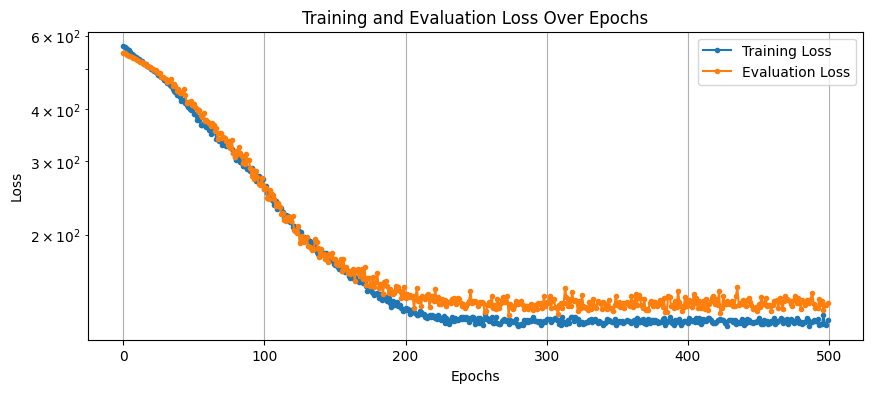

In [12]:
# Create the plot
plt.figure(figsize=(10, 4))
plt.plot(history_cb.history['train_loss'], label='Training Loss', marker='.')
plt.plot(history_cb.history['eval_loss'], label='Evaluation Loss', marker='.')

# Add titles and labels
plt.title('Training and Evaluation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

## Trained Model

In [13]:
from pythae.models import AutoModel

if TRAIN_FLAG:
    trained_model = model
else:
    trained_model = AutoModel.load_from_folder(glob.glob('experiments/*/final_model')[0])
    #trained_model = AutoModel.load_from_hf_hub(hf_hub_path="clementchadebec/reproduced_vae", allow_pickle=True)

# LATENT SPACE

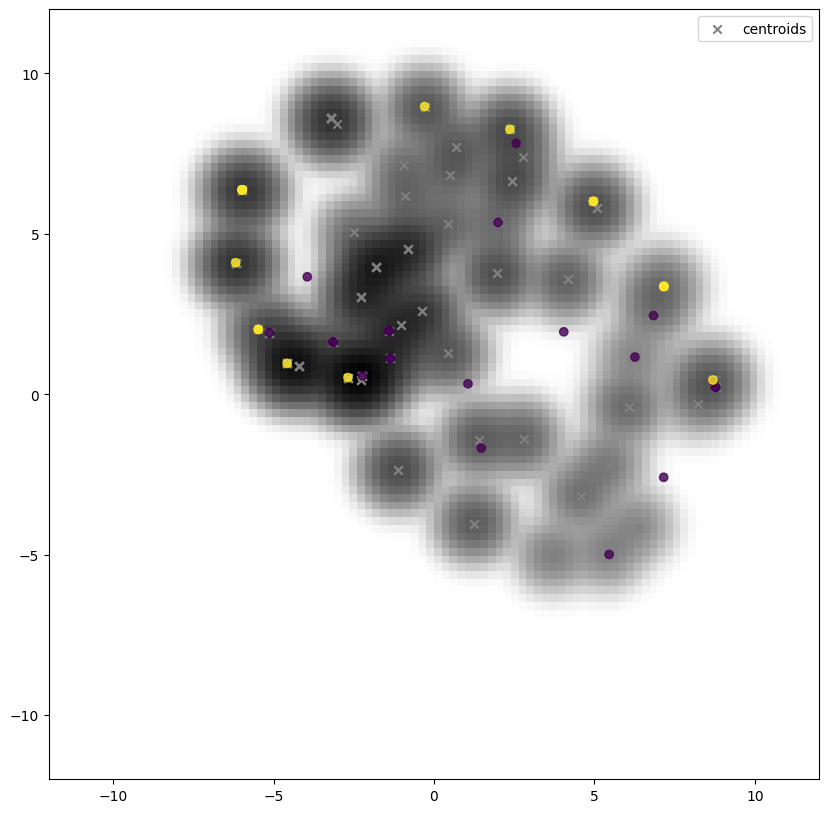

In [14]:
# You can also print the latent space when dealing with 2D latent spaces
plt.figure(figsize=(10, 10))
lim=12

train_latents = trained_model.encoder(train_dataset.to(device)).embedding.detach().cpu().numpy()
eval_latents = trained_model.encoder(eval_dataset.to(device)).embedding.detach().cpu().numpy()

X = torch.linspace(lim, -lim, 100).type(torch.float)
Y = torch.linspace(-lim, lim, 100).type(torch.float)
mesh = torch.tensor([[y, x] for x in X for y in Y]).to(device)

magn = (torch.sqrt(torch.det(trained_model.G(mesh))).detach().cpu().numpy().reshape(100, 100))
im = plt.imshow(np.log(magn), cmap='gray', extent=[-lim, lim, -lim, lim])
plt.scatter(trained_model.centroids_tens[:, 0].detach().cpu().numpy(), trained_model.centroids_tens[:, 1].detach().cpu().numpy(), c='gray', label='centroids', marker='x')
#plt.scatter(z_mean[:, 0], z_mean[:, 1], c='r', label='samples')
#plt.scatter(train_latents[:, 0], train_latents[:, 1], c='green', alpha=0.5, label='train samples')
plt.scatter(eval_latents[:, 0], eval_latents[:, 1], c=eval_labels, alpha=0.8)
plt.legend()

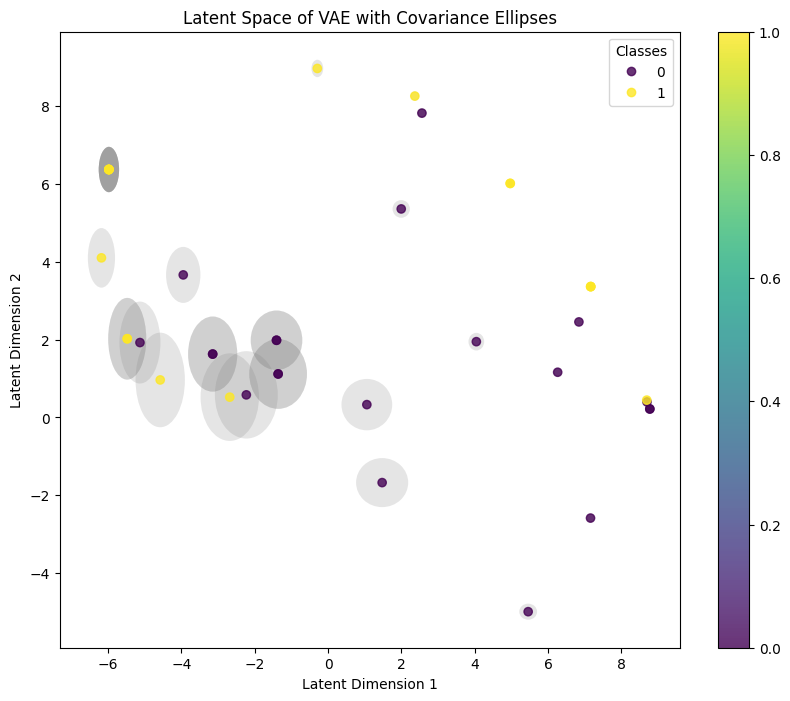

In [15]:
# Extract latent space representations
z_mean = trained_model.encoder(eval_dataset.to(device)).embedding.detach().cpu().numpy()
z_log_var = trained_model.encoder(eval_dataset.to(device)).log_covariance.detach().cpu().numpy()
y_test = eval_labels

# Plotting the latent space
def plot_cov_ellipse(mean, cov, ax, color='gray', nstd=1.0, **kwargs):
    """Plots an ellipse representing the covariance matrix."""
    from matplotlib.patches import Ellipse
    import matplotlib.transforms as transforms
    
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=color, edgecolor='none', **kwargs)
    
    scale_x = np.sqrt(cov[0, 0]) * nstd
    scale_y = np.sqrt(cov[1, 1]) * nstd
    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean[0], mean[1])
    
    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)

fig, ax = plt.subplots(figsize=(10, 8))

# Plot covariance ellipses
for i in range(len(z_mean)):
    cov = np.diag(np.exp(z_log_var[i]))
    plot_cov_ellipse(z_mean[i], cov, ax, color='gray', alpha=0.2)
    
scatter = ax.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='viridis', alpha=0.8)
legend = plt.legend(*scatter.legend_elements(), title="Classes")

plt.colorbar(scatter, ax=ax)
ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_title('Latent Space of VAE with Covariance Ellipses')
plt.show()

In [16]:
trained_model.metric

Metric_MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU()
  )
  (diag): Linear(in_features=400, out_features=2, bias=True)
  (lower): Linear(in_features=400, out_features=1, bias=True)
)

In [17]:
trained_model
# 'centroids',
 # 'centroids_tens', 
 # 'metric', 
 # 'G',
 # 'G_inv',
 # 'M',
 # 'M_tens',
 # 'T_destination',

RHVAE(
  (decoder): Decoder_AE_TinyMLP(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
  (encoder): Encoder_VAE_TinyMLP(
    (layers): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=400, bias=True)
      (2): ReLU()
    )
    (embedding): Linear(in_features=400, out_features=2, bias=True)
    (log_var): Linear(in_features=400, out_features=2, bias=True)
  )
  (metric): Metric_MLP(
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU()
    )
    (diag): Linear(in_features=400, out_features=2, bias=True)
    (lower): Linear(in_features=400, out_features=1, bias=True)
  )
)

# RECONSTRUCTIONS

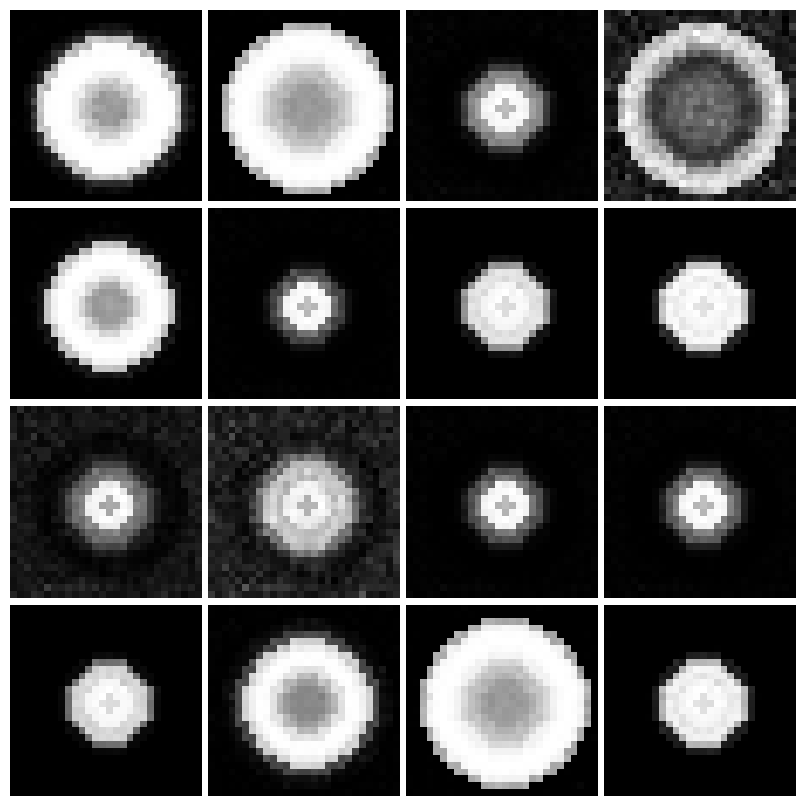

In [18]:
reconstructions = trained_model.reconstruct(eval_dataset[:25].to(device)).detach().cpu()

plot_grid(reconstructions)

# INTERPOLATIONS

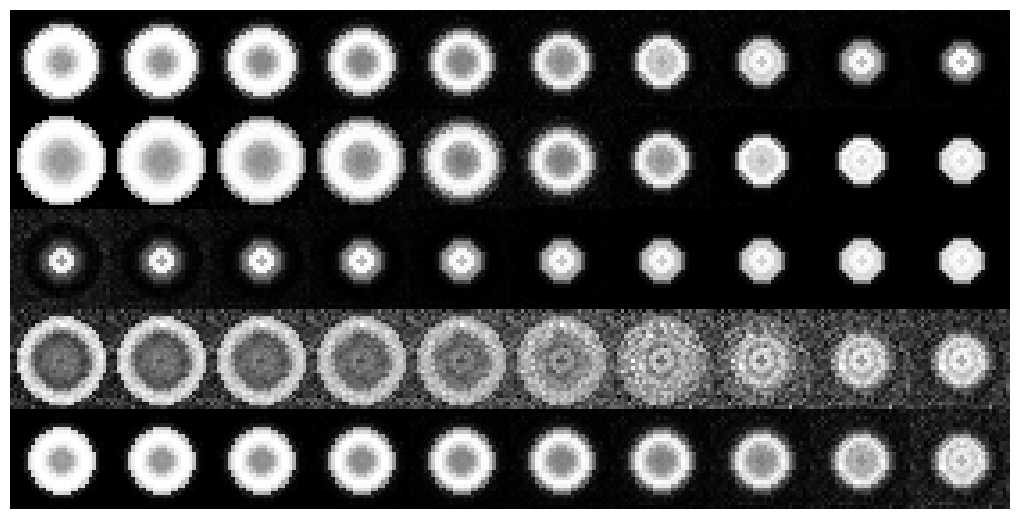

In [19]:
interpolations = trained_model.interpolate(eval_dataset[:5].to(device), eval_dataset[5:10].to(device), granularity=10).detach().cpu()

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 5))

for i in range(5):
    for j in range(10):
        axes[i][j].imshow(interpolations[i, j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

# GENERATE

### Metrics

In [20]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

# FID score computation class
fid_calculator = FrechetInceptionDistance(feature=64, reset_real_features=False, normalize=True)
fid_calculator.update(train_dataset.expand(train_dataset.shape[0], 3, img_size, img_size)[:200,].to('cpu'), real=True)

# IS score computation class
is_calculator = InceptionScore(normalize=True)

def compute_fid_score(gen_data):
    # Lower is better
    # greater sample variety
    fid_calculator.update(gen_data.expand(gen_data.shape[0], 3, img_size, img_size).cpu(), real=False)
    fid_score = fid_calculator.compute().item()
    print(f"FID = {fid_score:.4f}")
    return fid_score

def compute_is_score(gen_data):
    # Higher is better
    # better quality within individual images
    is_calculator.update(gen_data.expand(gen_data.shape[0], 3, img_size, img_size).cpu())
    is_score = is_calculator.compute()
    print(f"IS [mean] = {is_score[0].item():.4f}")
    print(f"IS [std] = {is_score[1].item():.4f}")


/home/dmandach/miniconda3/envs/py310/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


## Generators

### Normal Sampler

In [21]:
from pythae.samplers import NormalSampler

sampler = NormalSampler(
    model=trained_model,
    sampler_config=None
)
gen_data = sampler.sample(
    num_samples=25,
)

FID = 8.1104
IS [mean] = 1.4358
IS [std] = 0.2455


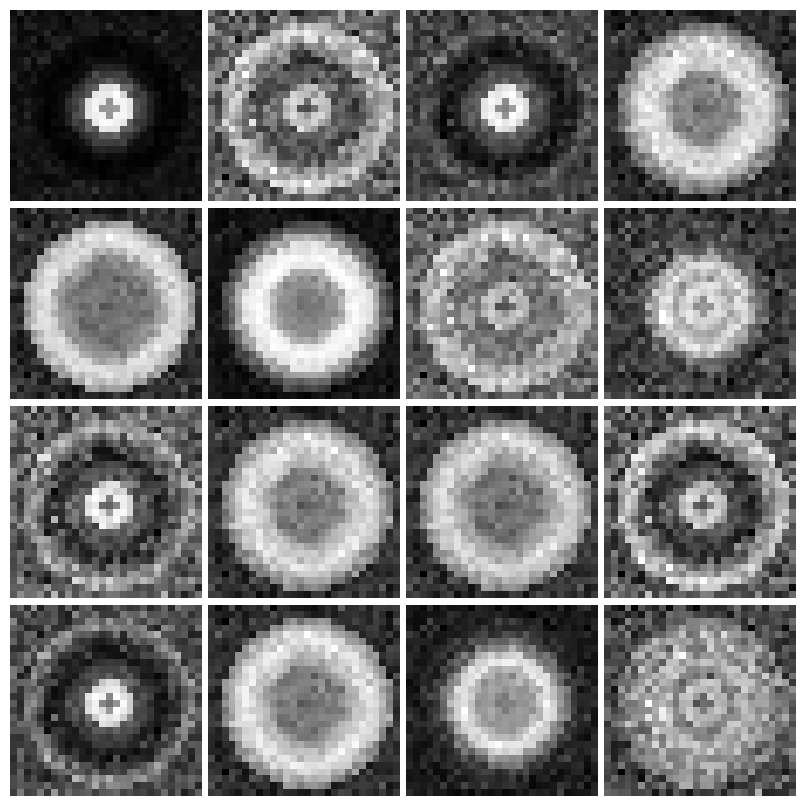

In [22]:
plot_grid(gen_data.data.cpu())
compute_fid_score(gen_data)
compute_is_score(gen_data)

### Gaussian Mixture Model Sampler

In [23]:
from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig


gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=2
)

gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

gmm_sampler.fit(
    train_data=train_dataset
)

gmm_gen_data = gmm_sampler.sample(
   num_samples=25
)

FID = 3.8369
IS [mean] = 1.7315
IS [std] = 0.1785


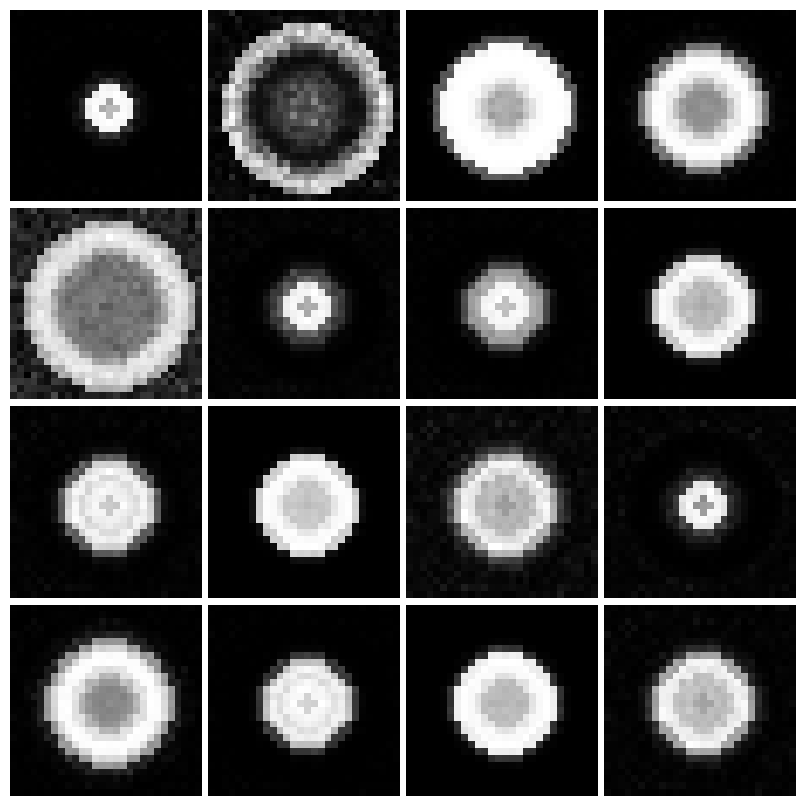

In [24]:
plot_grid(gmm_gen_data.data.cpu())
compute_fid_score(gmm_gen_data)
compute_is_score(gmm_gen_data)

### RHVAE Sampler

In [25]:
from pythae.samplers import RHVAESampler, RHVAESamplerConfig

rh_sampler_config = RHVAESamplerConfig(
    mcmc_steps_nbr = 100,
    n_lf = 15,
    eps_lf = 1e-3,
    beta_zero = 0.3
)

rh_sampler = RHVAESampler(
    sampler_config=rh_sampler_config,
    model=trained_model
)

rh_sampler.fit(
    train_data=train_dataset
)

rh_gen_data = rh_sampler.sample(
   num_samples=25
)

FID = 2.7135
IS [mean] = 1.7678
IS [std] = 0.1092


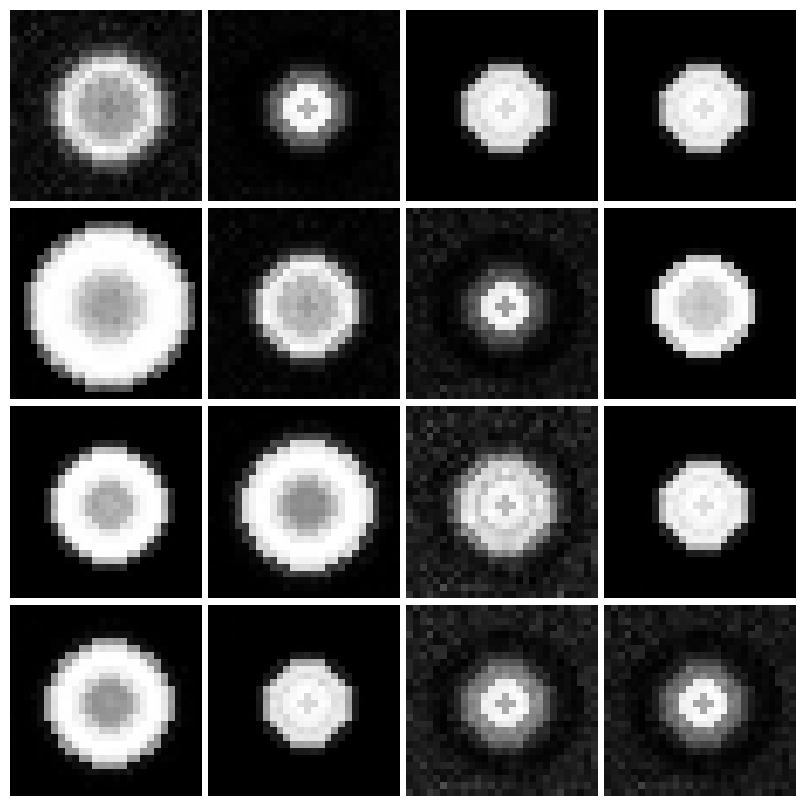

In [26]:
plot_grid(rh_gen_data.cpu())
compute_fid_score(rh_gen_data)
compute_is_score(rh_gen_data)